In [1]:
# Import dependencies
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
# Import dependencies
import numpy as np
import pandas as pd

In [3]:
# Import dependencies
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
# Create engine to .sqlite file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect = True)

In [7]:
# We can view all of the classes that automap found
hawaii = Base.classes.keys()
hawaii

['measurement', 'station']

In [8]:
# Save references to each table
measure = Base.classes.measurement
station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

Text(0, 0.5, 'Inches')

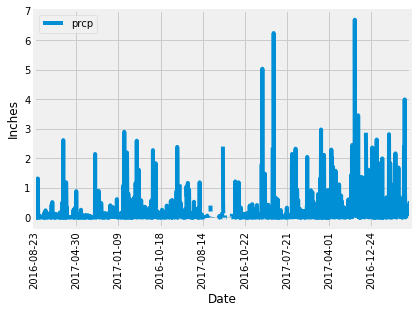

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
# Perform a query to retrieve the data and precipitation scores
climate = session.query(measure.date,measure.prcp).filter(measure.date.between(dt.date(2016,8,23),dt.date(2017,8,23))).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
climate_analysis = pd.DataFrame(climate,columns=['date','prcp'])
climate_analysis.set_index('date', inplace=True)

# Sort the dataframe by date
climate_analysis.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data
climate_analysis.plot(rot=90)
plt.xlabel("Date")
plt.ylabel("Inches")

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
precip_stats = climate_analysis.describe()
precip_stats

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [12]:
# Design a query to show how many stations are available in this dataset?
number_stations = session.query(measure.station).distinct().count()
print(f"Number of Stations: {number_stations}")

Number of Stations: 9


In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stations_active = session.query(measure.station,func.count(measure.station)).group_by(measure.station).order_by(func.count(measure.station).desc()).all()
print(f"Highest Active Stations")
stations_active

Highest Active Stations


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Creating a variable to print the most active station for next query
most_active = stations_active[0][0]
print(f"Highest Active Station: {most_active}")

Highest Active Station: USC00519281


In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
active_temp = session.query(func.min(measure.tobs), func.max(measure.tobs),
                                       func.avg(measure.tobs)).filter(measure.station == most_active).all()

print(f"Highest Active Station Temperatures:")
print(f"Min Temp: {active_temp[0][0]} Max Temp: {active_temp[0][1]} Avg Temp: {round(active_temp[0][2],1)}")

Highest Active Station Temperatures:
Min Temp: 54.0 Max Temp: 85.0 Avg Temp: 71.7


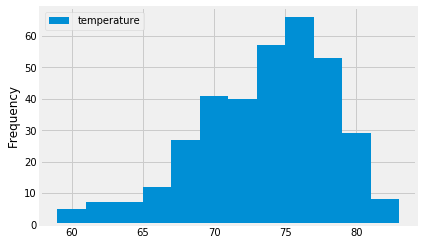

In [16]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_observ = session.query(measure.date,measure.tobs).filter(measure.date.between(dt.date(2016,8,23),dt.date(2017,12,31))).filter(measure.station == 'USC00519281').all()
temperature = pd.DataFrame(temp_observ, columns=['date','temperature'])
temperature.set_index('date', inplace=True)
temperature.plot.hist(bins = 12)
plt.show()

## Bonus Challenge Assignment

In [17]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measure.tobs), func.avg(measure.tobs), func.max(measure.tobs)).\
        filter(measure.date >= start_date).filter(measure.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [18]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
calc = calc_temps('2017-02-28','2017-03-05')
calc

[(64.0, 72.02777777777777, 78.0)]

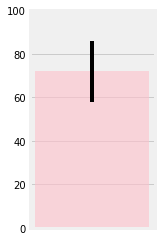

In [19]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

min_trip_temp = calc[0][0]
avg_trip_temp = calc[0][1]
max_trip_temp = calc[0][2]

minimum = avg_trip_temp - min_trip_temp
maximum = max_trip_temp - avg_trip_temp

plt.figure(figsize=(2,4))
plt.bar(0, avg_trip_temp, yerr=[max_trip_temp-min_trip_temp], color='pink', alpha=.6)
plt.ylim(0,100)
plt.xticks([])
plt.show()

In [20]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
rainfall_per_station= \
session.query(measure.prcp, station.station, station.name, station.latitude, station.longitude, station.elevation).\
filter(measure.station == station.station).\
filter(measure.date >= '2017-02-28').\
filter(measure.date <= '2017-03-05').\
group_by(measure.station).\
order_by(measure.prcp.desc()).all()

total_rainfall = pd.DataFrame(rainfall_per_station)
total_rainfall.fillna(0)

,prcp,station,name,latitude,longitude,elevation
0,0.58,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
1,0.16,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
2,0.04,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
3,0.04,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
4,0.00,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
5,0.00,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
6,0.00,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9


In [21]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(measure.tobs), func.avg(measure.tobs), func.max(measure.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", measure.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [22]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start = '2017-02-28'
end ='2017-03-05'

# Use the start and end date to create a range of dates
date_query = session.query(measure.date).filter(measure.date >= start).filter(measure.date <= end).group_by(measure.date).all()
date_of_trips = [x[0] for x in date_query]

# Stip off the year and save a list of %m-%d strings
list = [x[5:] for x in date_of_trips]
start_month = list[0]
end_month = list[-1]

# Loop through the list of %m-%d strings and calculate the normals for each date
daily_normals = [session.query(func.min(measure.tobs),
                       func.avg(measure.tobs),
                       func.max(measure.tobs)).filter(func.strftime("%m-%d", measure.date) >= start_month).filter(func.strftime("%m-%d", measure.date) <= end_month).group_by(func.strftime("%m-%d", measure.date)).all()]

# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals = daily_normals[0]
print("Daily Normals for Trip Dates 02-28 to 03-05:")
normals

Daily Normals for Trip Dates 02-28 to 03-05:


[(65.0, 70.65517241379311, 80.0),
 (67.0, 71.73333333333333, 79.0),
 (64.0, 70.0327868852459, 76.0),
 (61.0, 70.36666666666666, 78.0),
 (60.0, 70.06896551724138, 78.0),
 (57.0, 69.27272727272727, 77.0),
 (60.0, 67.89090909090909, 76.0)]

In [23]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
query_df= pd.DataFrame(normals,columns=['tmin', 'tavg', 'tmax'])
query_df

,tmin,tavg,tmax
0,65.0,70.655172,80.0
1,67.0,71.733333,79.0
2,64.0,70.032787,76.0
3,61.0,70.366667,78.0
4,60.0,70.068966,78.0
5,57.0,69.272727,77.0
6,60.0,67.890909,76.0


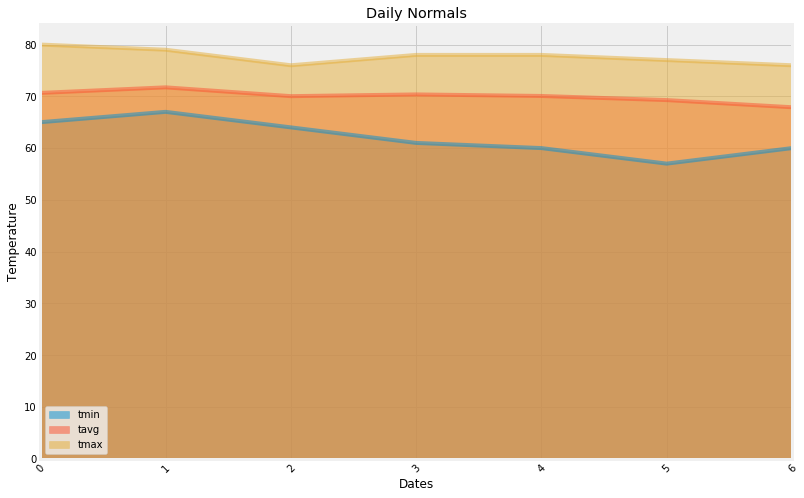

In [24]:
# Plot the daily normals as an area plot with `stacked=False`
query_df.plot(kind='area', figsize=(12, 8), stacked=False, title='Daily Normals', rot=45)

plt.xlabel('Dates')
plt.ylabel('Temperature')
plt.show()